In [20]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim
import io
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from tqdm import tqdm 
from skimage.metrics import structural_similarity as ssim
import lpips 
from torch.optim.lr_scheduler import LambdaLR
import random

In [ ]:
# The Augmentation is done already and handled in dataset itself so No need to rerun this part again

# ## Augmenting the Training Dataset to increase the training samples
# '''
# We just implemented simple Flips and Rotation methods as Augmentation initially-----> [will look into Blurs and Noising later half of project]

# '''

# def augment_images(dest_low, dest_high, num_augments=3):
#     os.makedirs(dest_low, exist_ok=True)
#     os.makedirs(dest_high, exist_ok=True)
    
#     existing_low = sorted(os.listdir(dest_low))
#     existing_high = sorted(os.listdir(dest_high))
    
#     start_idx = len(existing_low) + 1
    
#     for filename in existing_low:
#         if filename.startswith("low_") and filename.endswith(".jpg"):
#             idx = int(filename.split("_")[1].split(".")[0])
#             low_img_path = os.path.join(dest_low, filename)
#             high_img_path = os.path.join(dest_high, f'high_{idx}.jpg')
            
#             low_img = cv2.imread(low_img_path)
#             high_img = cv2.imread(high_img_path)
            
#             if low_img is None or high_img is None:
#                 continue
            
#             for i in range(1, num_augments + 1):
#                 aug_low = cv2.flip(low_img, 1) if i % 2 == 0 else cv2.rotate(low_img, cv2.ROTATE_90_CLOCKWISE)
#                 aug_high = cv2.flip(high_img, 1) if i % 2 == 0 else cv2.rotate(high_img, cv2.ROTATE_90_CLOCKWISE)
                
#                 cv2.imwrite(os.path.join(dest_low, f'low_{start_idx}.jpg'), aug_low)
#                 cv2.imwrite(os.path.join(dest_high, f'high_{start_idx}.jpg'), aug_high)
#                 start_idx += 1

# # Define paths
# base_dest = r"C:\Users\khare\Downloads\DATASET_LLE\TRAIN"

# dest_low = os.path.join(base_dest, "LOW_LIGHT")
# dest_high = os.path.join(base_dest, "HIGH_LIGHT")

# # Execute function
# augment_images(dest_low, dest_high, num_augments=3)


In [21]:
def set_seed(seed=42):
    """Set all random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed (choose any number you like)
set_seed(42) 

In [2]:
## Creating a Training DataLoader, Val DataLoader and Test DATA Loader

class LowLightDataset(Dataset):
    def __init__(self, low_light_dir, high_light_dir, transform=None):
        self.low_light_images = sorted(os.listdir(low_light_dir))
        self.high_light_images = sorted(os.listdir(high_light_dir))
        self.low_light_dir = low_light_dir
        self.high_light_dir = high_light_dir
        self.transform = transform

    def __len__(self):
        return len(self.low_light_images)

    def __getitem__(self, idx):
        low_img_path = os.path.join(self.low_light_dir, self.low_light_images[idx])
        high_img_path = os.path.join(self.high_light_dir, self.high_light_images[idx])
        
        low_img = Image.open(low_img_path).convert("RGB")
        high_img = Image.open(high_img_path).convert("RGB")

        if self.transform:
            low_img = self.transform(low_img)
            high_img = self.transform(high_img)

        return low_img, high_img

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

#----------------# Load dataloaders-----------------------------------
path = r"/home/gsalsabil2/deep_learning/DATASET_LLE/"
#Train_DATALOADER
train_low_path = path + r"/TRAIN/LOW_LIGHT"
train_high_path =  path + r"/TRAIN/HIGH_LIGHT"
train_dataset = LowLightDataset(train_low_path, train_high_path, transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

#Val_DATALOADER
val_low_path = path + r"/VAL/LOW_LIGHT"
val_high_path =  path + r"/VAL/HIGH_LIGHT"
val_dataset = LowLightDataset(val_low_path, val_high_path, transform)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

#Test_DATALOADER
test_low_path =  path + r"/TEST/LOW_LIGHT"
test_high_path =  path + r"/TEST/HIGH_LIGHT"
test_dataset = LowLightDataset(test_low_path, test_high_path, transform)
test_loader = DataLoader(test_dataset, batch_size=8)

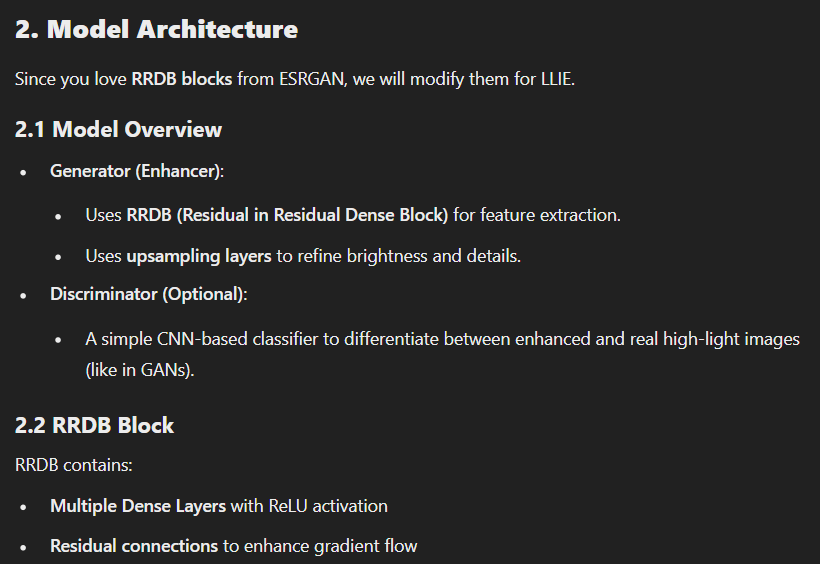

In [5]:
## RRDB blocks architecture derived from the paper ESRGAN..

class ResidualDenseBlock(nn.Module):
    def __init__(self, in_channels=64, growth_rate=32):
        super(ResidualDenseBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels + growth_rate, growth_rate, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels + 2 * growth_rate, in_channels, kernel_size=3, padding=1)

    def forward(self, x):
        out1 = torch.relu(self.conv1(x))
        out2 = torch.relu(self.conv2(torch.cat([x, out1], dim=1)))
        out3 = self.conv3(torch.cat([x, out1, out2], dim=1))
        return x + out3

class RRDB(nn.Module):
    def __init__(self, in_channels=64, beta=0.2):  
        super(RRDB, self).__init__()
        self.rdb1 = ResidualDenseBlock(in_channels)
        self.rdb2 = ResidualDenseBlock(in_channels)
        self.rdb3 = ResidualDenseBlock(in_channels)
        self.beta = beta  # Scaling factor for residual

    def forward(self, x):
        residual = self.rdb3(self.rdb2(self.rdb1(x)))
        return x + self.beta * residual  # Scaled residual for stability

In [6]:
class Generator(nn.Module):
    def __init__(self, num_rrdb=6):
        super(Generator, self).__init__()

        # Initial feature extraction
        self.initial_conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # RRDB Blocks
        self.rrdb_blocks = nn.Sequential(*[RRDB(64) for _ in range(num_rrdb)])

        # Global Residual Path (helps learn overall brightness correction)
        self.global_residual = nn.Conv2d(3, 3, kernel_size=3, padding=1)

        # Final convolution layers for reconstruction
        self.final_conv = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=3, padding=1)
        )

    def forward(self, x):
        initial_features = self.initial_conv(x)
        enhanced_features = self.rrdb_blocks(initial_features)
        reconstructed = self.final_conv(enhanced_features)
        
        # Adding the global residual path
        output = reconstructed + self.global_residual(x)
        
        return torch.sigmoid(output)  # Normalize output to [0,1]

In [7]:
'''  Use a Discriminator (GAN Approach)
        This makes the enhanced image look more realistic by forcing the Generator to fool a Discriminator.
        USES PatchGANDiscriminator idea as the Discriminator'''

class PatchGANDiscriminator(nn.Module):
    def __init__(self, in_channels=3, num_filters=64, num_layers=3):
        super(PatchGANDiscriminator, self).__init__()
        
        # Initial convolutional layer
        layers = [
            nn.Conv2d(in_channels, num_filters, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        
        # Intermediate convolutional layers
        for i in range(1, num_layers):
            layers += [
                nn.Conv2d(num_filters * (2 ** (i - 1)), num_filters * (2 ** i), kernel_size=4, stride=2, padding=1),
                nn.InstanceNorm2d(num_filters * (2 ** i)),
                nn.LeakyReLU(0.2, inplace=True)
            ]
        
        # Final convolutional layer
        layers += [
            nn.Conv2d(num_filters * (2 ** (num_layers - 1)), 1, kernel_size=4, stride=1, padding=1)
        ]
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)  # Output shape: [batch_size, 1, H, W]

In [8]:
## Loss Functions

# L1 Loss (Pixel-Level Difference)
l1_loss = nn.L1Loss()

# Perceptual Loss using VGG-19 Features
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg19(pretrained=True).features[:16]  # Use first few layers
        for param in vgg.parameters():
            param.requires_grad = False  # Freeze VGG model
        self.vgg = vgg.eval()
        self.criterion = nn.L1Loss()

    def forward(self, x, y):
        x_features = self.vgg(x)
        y_features = self.vgg(y)
        return self.criterion(x_features, y_features)


perceptual_loss = PerceptualLoss()
bce_loss = nn.BCEWithLogitsLoss()

/home/gsalsabil2/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gsalsabil2/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# ##optimizer
# # import torch.optim as optim

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# # optimizer = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.9, 0.999))
# # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # Decay LR every 20 epochs

In [9]:
## Common evaluating Metrics
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## PSNR
def psnr(img1, img2):
    mse = F.mse_loss(img1, img2)
    psnr_value = 20 * torch.log10(1.0 / torch.sqrt(mse))  # Assuming pixel values in [0,1]
    return psnr_value.item()

lpips_loss = lpips.LPIPS(net='alex').to(device)   # Use AlexNet-based LPIPS
def compute_lpips(img1, img2):
    # The inputs must match on the same device either Cuda or CPU (Device variable guarantees this)
    
    img1 = img1.to(device) 
    img2 = img2.to(device)  
    
    # change into [-1,1]
    img1 = (img1 * 2) - 1
    img2 = (img2 * 2) - 1
    
    # Compute LPIPS for each pair of images in the batch
    lpips_values = []
    for i in range(img1.shape[0]):  # Iterate over the batch dimension
        lpips_values.append(lpips_loss(img1[i:i+1], img2[i:i+1]).item())
    
    return sum(lpips_values) / len(lpips_values)  # Return the average LPIPS for the batch

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/gsalsabil2/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/gsalsabil2/.local/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


In [10]:
def val_model(generator, val_loader):
    generator.eval()
    total_psnr = 0.0
    total_lpips = 0.0
    val_loss=0.0
    count = 0

    with torch.no_grad():
        for low_light, high_light in val_loader:
            low_light, high_light = low_light.to(device), high_light.to(device)
            enhanced = generator(low_light)

            # Validation loss (L1 + perceptual)
            val_loss += (10 * F.l1_loss(enhanced, high_light) + 0.1 * perceptual_loss(enhanced, high_light)).item()
            
            # Compute PSNR
            psnr_value = psnr(enhanced, high_light)
            total_psnr += psnr_value
            
            # Compute LPIPS (Perceptual Distance)
            lpips_value = compute_lpips(enhanced, high_light)
            total_lpips += lpips_value

            count += 1
    mean_psnr=total_psnr / count
    mean_lpips=total_lpips/count
    mean_loss = val_loss/count
    # print(f"Avg PSNR: {total_psnr / count:.4f}")
    # print(f"Avg LPIPS: {total_lpips / count:.4f}")
    return mean_loss, mean_psnr, mean_lpips
# # Run evaluation
# evaluate_model(generator, test_loader)

generator-discriminator 1-1 

Source: https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan_gp/wgan_gp.py

In [11]:
def compute_gradient_penalty(disc, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = disc(interpolates)
    fake = torch.ones_like(d_interpolates)
    
    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [12]:
train_metrics = {
    'epoch': [],
    'g_loss': [],
    'd_loss': [],
    'g_scheduler':[],
    'd_scheduler':[]}

val_metrics = {
    'epoch': [],
    'val_loss': [],
    'psnr': [],
    'lpips': []
}

In [11]:
# Initialize models and optimizers

generator = Generator().to(device)
discriminator = PatchGANDiscriminator().to(device)
gen_optimizer = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
disc_optimizer = optim.Adam(discriminator.parameters(), lr = 4e-4, betas=(0.5, 0.999))

# Loss Functions
adversarial_loss = nn.BCEWithLogitsLoss()
pixel_loss = nn.L1Loss()
perceptual_loss = PerceptualLoss().to(device)

# Training Loop
num_epochs = 300
disc_iterations = 0  # Counter for discriminator iterations
best_val_psnr = 0
# os.makedirs("saved_models2(1-1)", exist_ok=True)

# After optimizer initialization:
def lr_lambda(epoch):
    if epoch < 50:
        return 1.0  # Warmup
    else:
        return 0.95 ** (epoch - 50)  # Gradual decay

gen_scheduler = LambdaLR(gen_optimizer, lr_lambda)
disc_scheduler = LambdaLR(disc_optimizer, lr_lambda)


for epoch in range(num_epochs):
    generator.train()
    discriminator.train()
    
    epoch_g_loss = 0.0
    epoch_d_loss = 0.0
    g_update_count = 0 

    loop = tqdm(train_loader, leave=True)
    for batch_idx ,(low_light, high_light) in enumerate(loop):
        low_light, high_light = low_light.to(device), high_light.to(device)

        ####### Train Discriminator #######
        disc_optimizer.zero_grad()

        # Get discriminator output shape
        real_preds = discriminator(high_light)
        
        with torch.no_grad():
            fake = generator(low_light)
        fake_high_light = fake.detach()
        fake_preds = discriminator(fake_high_light)
        
        # Create target labels with the same shape as discriminator output
        real_labels = torch.ones_like(real_preds) * 0.9  # Label smoothing
        fake_labels = torch.zeros_like(fake_preds) + 0.1

        # Calculate discriminator loss
        gp = compute_gradient_penalty(discriminator, high_light.data, fake.data)
        d_real_loss = adversarial_loss(real_preds, real_labels)
        d_fake_loss = adversarial_loss(fake_preds, fake_labels)
        d_loss = (d_real_loss + d_fake_loss) / 2 + 10*gp
        d_loss.backward()
        disc_optimizer.step()
        epoch_d_loss += d_loss.item()
        disc_iterations += 1
        
        ####### Train Generator #######
        gen_optimizer.zero_grad()

        fake_high_light = generator(low_light)
        fake_preds = discriminator(fake_high_light)

        # Calculate generator loss
        g_adv_loss = adversarial_loss(fake_preds, real_labels)  # Fool the discriminator
        g_pixel_loss = pixel_loss(fake_high_light, high_light)  # Maintain structure
        g_perceptual_loss = perceptual_loss(fake_high_light, high_light)  # Texture similarity

        g_loss = g_adv_loss + 10 * g_pixel_loss + 0.1 * g_perceptual_loss  # Weighted sum
        g_loss.backward()
        gen_optimizer.step()

        epoch_g_loss += g_loss.item()
        epoch_d_loss += d_loss.item()
        # g_update_count += 1 
        current_g_loss = g_loss.item() 
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(G_Loss=current_g_loss, D_Loss=d_loss.item())

    print(f"Epoch {epoch+1}: Generator Loss: {epoch_g_loss/len(train_loader):.4f}, Discriminator Loss: {epoch_d_loss/len(train_loader):.4f}")
    print(f"Gradient Penalty: {gp.item():.4f}")
    train_metrics['epoch'].append(int(epoch+1))
    train_metrics['g_loss'].append(epoch_g_loss/len(train_loader))
    train_metrics['d_loss'].append(epoch_d_loss/len(train_loader))
    
    gen_scheduler.step()
    disc_scheduler.step()
    print(f"Updated LRs - Gen: {gen_optimizer.param_groups[0]['lr']:.2e} | Disc: {disc_optimizer.param_groups[0]['lr']:.2e}")
    train_metrics['g_scheduler'].append(gen_optimizer.param_groups[0]['lr'])
    train_metrics['d_scheduler'].append(disc_optimizer.param_groups[0]['lr'])
    
    if (epoch + 1) % 2 == 0:
        loss_val, psnr_val, lpips_val = val_model(generator, val_loader)
        print(f"Validation - Val.Loss: {loss_val:.4f} | PSNR: {psnr_val:.4f} | LPIPS: {lpips_val:.4f}")
        val_metrics['epoch'].append(int(epoch+1))
        val_metrics['val_loss'].append(loss_val)
        val_metrics['psnr'].append(psnr_val)
        val_metrics['lpips'].append(lpips_val)
        if psnr_val > best_val_psnr:
            best_val_psnr = psnr_val
            up_val_lpips = lpips_val 
            os.makedirs("saved_models2(1-1)", exist_ok=True)
            torch.save(generator.state_dict(), "saved_models2(1-1)/best_generator1.pth")
            torch.save(discriminator.state_dict(), "saved_models2(1-1)/best_discriminator1.pth")
    if (epoch + 1) % 5 == 0:
        torch.save(generator.state_dict(), f"saved_models2(1-1)/generator_epoch_{epoch+1}.pth")
        torch.save(discriminator.state_dict(), f"saved_models2(1-1)/discriminator_epoch_{epoch+1}.pth")
    
    print("\n")


  0%|          | 0/198 [00:03<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 196.00 MiB. GPU 0 has a total capacity of 44.43 GiB of which 89.75 MiB is free. Process 3487825 has 20.44 GiB memory in use. Process 3520173 has 788.00 MiB memory in use. Process 3527473 has 2.52 GiB memory in use. Process 3764409 has 1.98 GiB memory in use. Process 3972920 has 11.64 GiB memory in use. Including non-PyTorch memory, this process has 6.95 GiB memory in use. Of the allocated memory 6.29 GiB is allocated by PyTorch, and 169.22 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

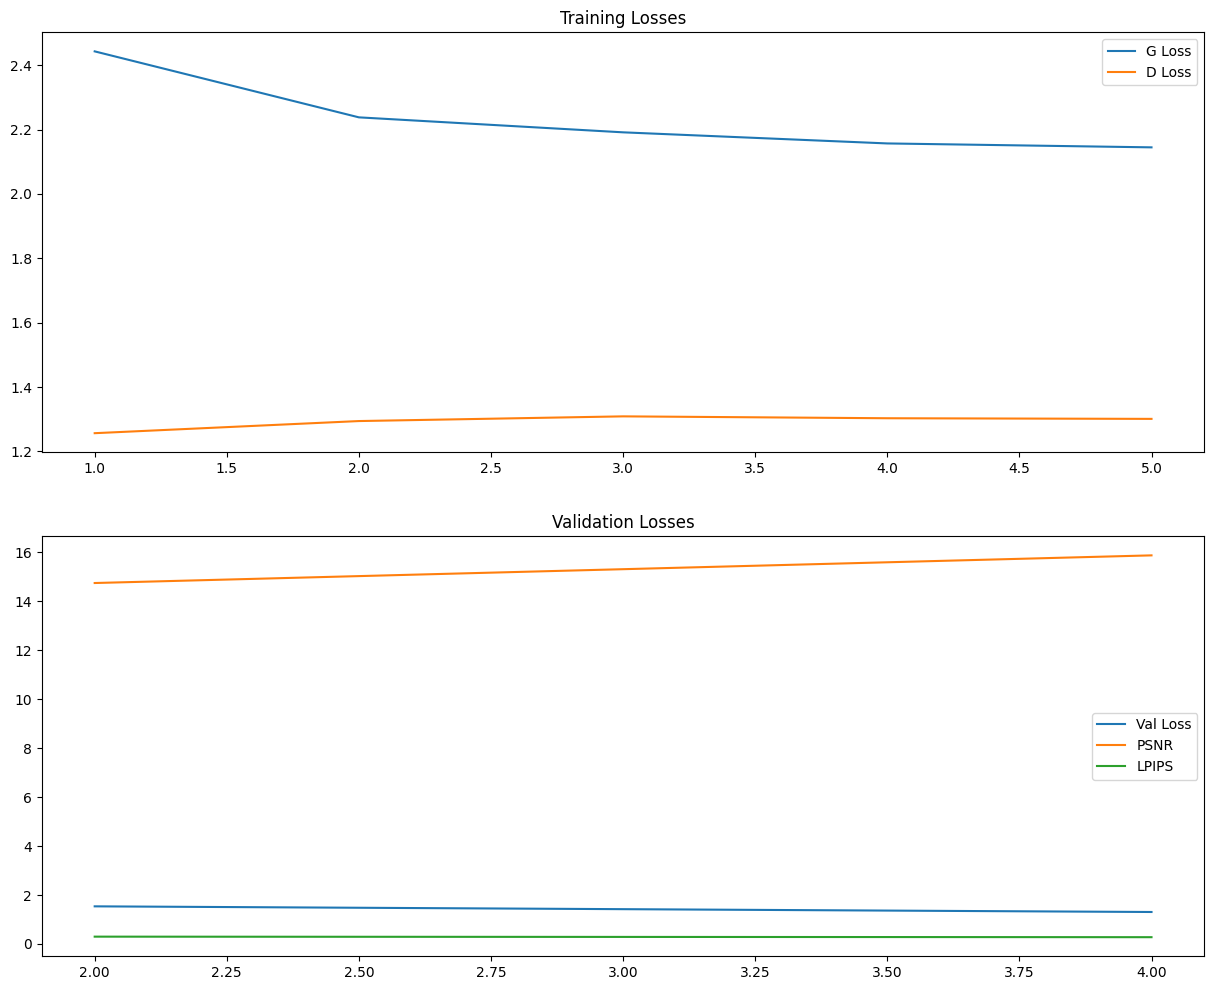

In [20]:
plt.figure(figsize=(15, 12))
        
plt.subplot(2, 1, 1)
plt.plot(train_metrics['epoch'], train_metrics['g_loss'], label='G Loss')
plt.plot(train_metrics['epoch'], train_metrics['d_loss'], label='D Loss')
plt.title('Training Losses')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(val_metrics['epoch'], val_metrics['val_loss'], label='Val Loss')
plt.plot(val_metrics['epoch'], val_metrics['psnr'], label='PSNR')
plt.plot(val_metrics['epoch'], val_metrics['lpips'], label='LPIPS')
plt.title('Validation Losses')
plt.legend()
plt.show()

Without early stop, generator discriminator 1:3

In [ ]:
# # Initialize models and optimizers

# generator = Generator().to(device)
# discriminator = PatchGANDiscriminator().to(device)
# gen_optimizer = optim.Adam(generator.parameters(), lr=5e-4, betas=(0.5, 0.999))
# disc_optimizer = optim.Adam(discriminator.parameters(), lr = 2e-4, betas=(0.5, 0.999))

# # Loss Functions
# adversarial_loss = nn.BCEWithLogitsLoss()
# pixel_loss = nn.L1Loss()
# perceptual_loss = PerceptualLoss().to(device)

# # Training Loop
# num_epochs = 500
# disc_iterations = 0  # Counter for discriminator iterations
# best_val_psnr = 0

# for epoch in range(num_epochs):
#     generator.train()
#     discriminator.train()
    
#     epoch_g_loss = 0.0
#     epoch_d_loss = 0.0
#     g_update_count = 0 

#     loop = tqdm(train_loader, leave=True)
#     for batch_idx ,(low_light, high_light) in enumerate(loop):
#         low_light, high_light = low_light.to(device), high_light.to(device)

#         ####### Train Discriminator #######
#         disc_optimizer.zero_grad()

#         # Get discriminator output shape
#         real_preds = discriminator(high_light)
#         fake_high_light = generator(low_light).detach()
#         fake_preds = discriminator(fake_high_light)

#         # Create target labels with the same shape as discriminator output
#         real_labels = torch.ones_like(real_preds) * 0.9  # Label smoothing
#         fake_labels = torch.zeros_like(fake_preds) + 0.1

#         # Calculate discriminator loss
#         d_real_loss = adversarial_loss(real_preds, real_labels)
#         d_fake_loss = adversarial_loss(fake_preds, fake_labels)
#         d_loss = (d_real_loss + d_fake_loss) / 2
#         d_loss.backward()
#         disc_optimizer.step()
#         epoch_d_loss += d_loss.item()
#         disc_iterations += 1
        
#         ####### Train Generator #######
#         if disc_iterations % 3 == 0 or (epoch == 0 and batch_idx == 0):
#             gen_optimizer.zero_grad()

#             fake_high_light = generator(low_light)
#             fake_preds = discriminator(fake_high_light)

#             # Calculate generator loss
#             g_adv_loss = adversarial_loss(fake_preds, real_labels)  # Fool the discriminator
#             g_pixel_loss = pixel_loss(fake_high_light, high_light)  # Maintain structure
#             g_perceptual_loss = perceptual_loss(fake_high_light, high_light)  # Texture similarity

#             g_loss = g_adv_loss + 10 * g_pixel_loss + 0.1 * g_perceptual_loss  # Weighted sum
#             g_loss.backward()
#             gen_optimizer.step()

#             epoch_g_loss += g_loss.item()
#             epoch_d_loss += d_loss.item()
#             g_update_count += 1 
#         current_g_loss = g_loss.item() if disc_iterations % 5 == 0 else 0
#         loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
#         loop.set_postfix(G_Loss=current_g_loss, D_Loss=d_loss.item())

#     print(f"Epoch {epoch+1}: Generator Loss: {epoch_g_loss/g_update_count:.4f}, Discriminator Loss: {epoch_d_loss/len(train_loader):.4f}")

#     # Validate every 2 epochs
#     if (epoch + 1) % 2 == 0:
#         psnr_val, lpips_val = val_model(generator, val_loader)
#         print(f"Validation - PSNR: {psnr_val:.4f} | LPIPS: {lpips_val:.4f}")
#         if psnr_val > best_val_psnr:
#             best_val_psnr = psnr_val
#             up_val_lpips = lpips_val 
#             os.makedirs("saved_models", exist_ok=True)
#             torch.save(generator.state_dict(), "saved_models/best_generator1.pth")
#             torch.save(discriminator.state_dict(), "saved_models/best_discriminator1.pth")
#     if (epoch + 1) % 5 == 0:
#         torch.save(generator.state_dict(), f"saved_models/generator_epoch_{epoch+1}.pth")
#         torch.save(discriminator.state_dict(), f"saved_models/discriminator_epoch_{epoch+1}.pth")


  0%|          | 0/198 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 14.00 MiB. GPU 0 has a total capacity of 44.43 GiB of which 6.38 MiB is free. Process 3487825 has 20.44 GiB memory in use. Process 3520173 has 788.00 MiB memory in use. Process 3527473 has 2.52 GiB memory in use. Including non-PyTorch memory, this process has 20.67 GiB memory in use. Of the allocated memory 20.13 GiB is allocated by PyTorch, and 50.80 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

With early stop, generator discriminator 1:5

In [ ]:
# # Initialize models and optimizers

# generator = Generator().to(device)
# discriminator = PatchGANDiscriminator().to(device)
# gen_optimizer = optim.Adam(generator.parameters(), lr=5e-4, betas=(0.5, 0.999))
# disc_optimizer = optim.Adam(discriminator.parameters(), lr = 2e-4, betas=(0.5, 0.999))

# # Loss Functions
# adversarial_loss = nn.BCEWithLogitsLoss()
# pixel_loss = nn.L1Loss()
# perceptual_loss = PerceptualLoss().to(device)

# # Training Loop
# num_epochs = 500
# disc_iterations = 0  # Counter for discriminator iterations
# best_val_psnr = 0
# patience = 20  
# no_improve_epochs = 0
# early_stop = False

# for epoch in range(num_epochs):
#     generator.train()
#     discriminator.train()
    
#     epoch_g_loss = 0.0
#     epoch_d_loss = 0.0
#     g_update_count = 0 

#     loop = tqdm(train_loader, leave=True)
#     for batch_idx ,(low_light, high_light) in enumerate(loop):
#         low_light, high_light = low_light.to(device), high_light.to(device)

#         ####### Train Discriminator #######
#         disc_optimizer.zero_grad()

#         # Get discriminator output shape
#         real_preds = discriminator(high_light)
#         fake_high_light = generator(low_light).detach()
#         fake_preds = discriminator(fake_high_light)

#         # Create target labels with the same shape as discriminator output
#         real_labels = torch.ones_like(real_preds) * 0.9  # Label smoothing
#         fake_labels = torch.zeros_like(fake_preds) + 0.1

#         # Calculate discriminator loss
#         d_real_loss = adversarial_loss(real_preds, real_labels)
#         d_fake_loss = adversarial_loss(fake_preds, fake_labels)
#         d_loss = (d_real_loss + d_fake_loss) / 2
#         d_loss.backward()
#         disc_optimizer.step()
#         epoch_d_loss += d_loss.item()
#         disc_iterations += 1
        
#         ####### Train Generator #######
#         if disc_iterations % 5 == 0 or (epoch == 0 and batch_idx == 0):
#             gen_optimizer.zero_grad()

#             fake_high_light = generator(low_light)
#             fake_preds = discriminator(fake_high_light)

#             # Calculate generator loss
#             g_adv_loss = adversarial_loss(fake_preds, real_labels)  # Fool the discriminator
#             g_pixel_loss = pixel_loss(fake_high_light, high_light)  # Maintain structure
#             g_perceptual_loss = perceptual_loss(fake_high_light, high_light)  # Texture similarity

#             g_loss = g_adv_loss + 10 * g_pixel_loss + 0.1 * g_perceptual_loss  # Weighted sum
#             g_loss.backward()
#             gen_optimizer.step()

#             epoch_g_loss += g_loss.item()
#             epoch_d_loss += d_loss.item()
#             g_update_count += 1 
#         current_g_loss = g_loss.item() if disc_iterations % 5 == 0 else 0
#         loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
#         loop.set_postfix(G_Loss=current_g_loss, D_Loss=d_loss.item())

#     print(f"Epoch {epoch+1}: Generator Loss: {epoch_g_loss/g_update_count:.4f}, Discriminator Loss: {epoch_d_loss/len(train_loader):.4f}")

#     # Validate every 2 epochs
#     if (epoch + 1) % 2 == 0:
#         psnr_val, lpips_val = val_model(generator, val_loader)
#         print(f"Validation - PSNR: {psnr_val:.4f} | LPIPS: {lpips_val:.4f}")
#         if psnr_val > best_val_psnr:
#             best_val_psnr = psnr_val
#             no_improve_epochs = 0 
#             os.makedirs("saved_models", exist_ok=True)
#             torch.save(generator.state_dict(), "saved_models/best_generator.pth")
#             torch.save(discriminator.state_dict(), "saved_models/best_discriminator.pth")
#         else:
#             no_improve_epochs += 1
#             if no_improve_epochs >= patience:
#                 early_stop = True
                
#     if early_stop:
#         print(f"Early stopping at epoch {epoch+1}")
#         break
#         # torch.save(generator.state_dict(), f"generator_epoch_{epoch+1}.pth")
#         # torch.save(discriminator.state_dict(), f"discriminator_epoch_{epoch+1}.pth")


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = Generator().to(device)
generator.load_state_dict(torch.load("saved_models2(1-1)/best_generator1.pth", map_location=torch.device('cpu')))
generator.eval()

Generator(
  (initial_conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (rrdb_blocks): Sequential(
    (0): RRDB(
      (rdb1): ResidualDenseBlock(
        (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (rdb2): ResidualDenseBlock(
        (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (rdb3): ResidualDenseBlock(
        (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     

In [17]:
def evaluate_model(generator, test_loader):
    generator.eval()
    total_psnr = 0.0
    list_pnsr = []
    total_lpips = 0.0
    list_lpips = []
    count = 0

    with torch.no_grad():
        for low_light, high_light in test_loader:
            low_light, high_light = low_light.to(device), high_light.to(device)
            enhanced = generator(low_light)

            # Compute PSNR
            psnr_value = psnr(enhanced, high_light)
            list_pnsr.append(psnr_value)
            total_psnr += psnr_value
            
            # Compute LPIPS (Perceptual Distance)
            lpips_value = compute_lpips(enhanced, high_light)
            list_lpips.append(lpips_value)
            total_lpips += lpips_value

            count += 1

    print(f"Avg PSNR: {total_psnr / count:.4f}")
    print(f"Avg LPIPS: {total_lpips / count:.4f}")
    print(f"Ave SSIM: {np.average(list_pnsr)}")
    print(f"Ave SSIM: {np.average(list_lpips)}")
    print(F"Max PSNR: {max(list_pnsr)}")
    print(F"Max LPIPS: {max(list_lpips)}")
    print(F"Min PSNR: {min(list_pnsr)}")
    print(F"Min LPIPS: {min(list_lpips)}")
    print(f"Standard Dev PSNR: {np.std(list_pnsr)}")
    print(f"Standard Dev LPIPS: {np.std(list_lpips)}")
    return list_pnsr, list_lpips

# Run evaluation
list_pnsr, list_lpips = evaluate_model(generator, test_loader)

Avg PSNR: 16.0153
Avg LPIPS: 0.1281
Ave SSIM: 16.01533737182617
Ave SSIM: 0.12805101983249187
Max PSNR: 19.02135467529297
Max LPIPS: 0.15998710691928864
Min PSNR: 13.831567764282227
Min LPIPS: 0.0990366842597723
Standard Dev PSNR: 1.82204751307279
Standard Dev LPIPS: 0.01936154388432638


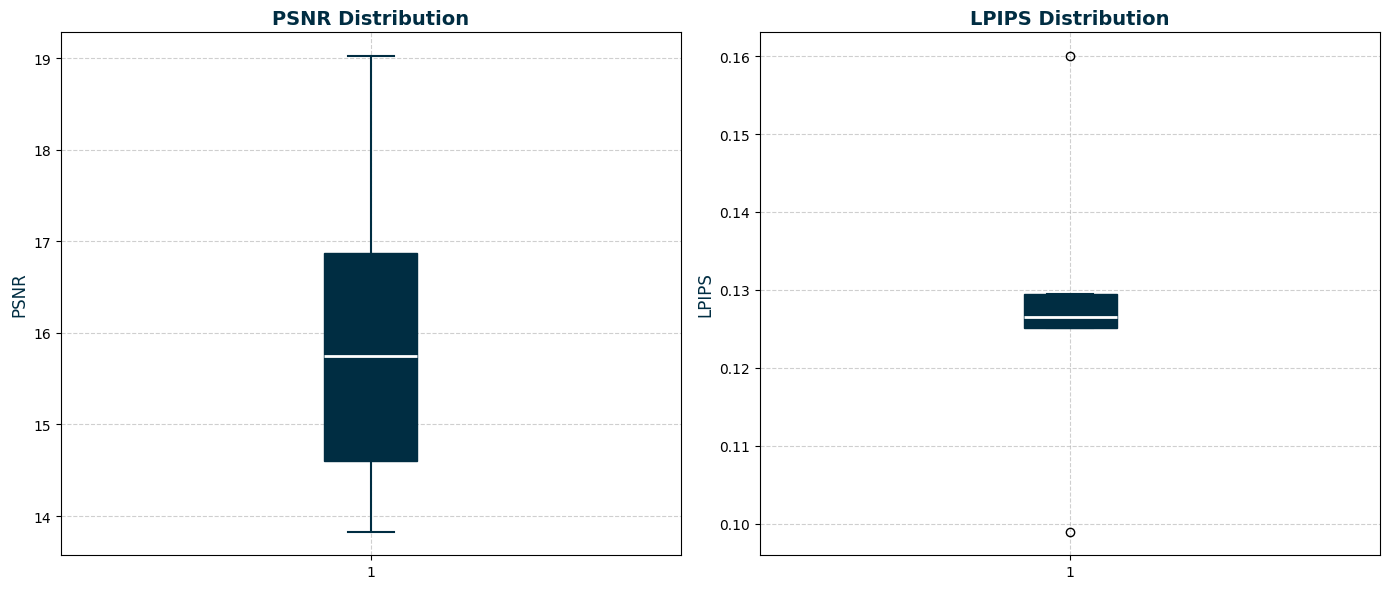

In [18]:
import matplotlib.pyplot as plt

def create_boxplot(list_pnsr, list_lpips):
    dark_blue = "#002D42"  # Extracted from the provided image

    fig, ax = plt.subplots(1, 2, figsize=(14, 6), dpi=100)

    # PSNR Boxplot
    box1 = ax[0].boxplot(list_pnsr, patch_artist=True, 
                          boxprops=dict(facecolor=dark_blue, color=dark_blue),
                          medianprops=dict(color="white", linewidth=2),
                          whiskerprops=dict(color=dark_blue, linewidth=1.5),
                          capprops=dict(color=dark_blue, linewidth=1.5))
    ax[0].set_title("PSNR Distribution", fontsize=14, fontweight="bold", color=dark_blue)
    ax[0].set_ylabel("PSNR", fontsize=12, color=dark_blue)
    ax[0].grid(True, linestyle="--", alpha=0.6)

    # LPIPS Boxplot
    box2 = ax[1].boxplot(list_lpips, patch_artist=True, 
                          boxprops=dict(facecolor=dark_blue, color=dark_blue),
                          medianprops=dict(color="white", linewidth=2),
                          whiskerprops=dict(color=dark_blue, linewidth=1.5),
                          capprops=dict(color=dark_blue, linewidth=1.5))
    ax[1].set_title("LPIPS Distribution", fontsize=14, fontweight="bold", color=dark_blue)
    ax[1].set_ylabel("LPIPS", fontsize=12, color=dark_blue)
    ax[1].grid(True, linestyle="--", alpha=0.6)

    # Overall Styling
    plt.tight_layout()
    plt.show()

create_boxplot(list_pnsr, list_lpips)

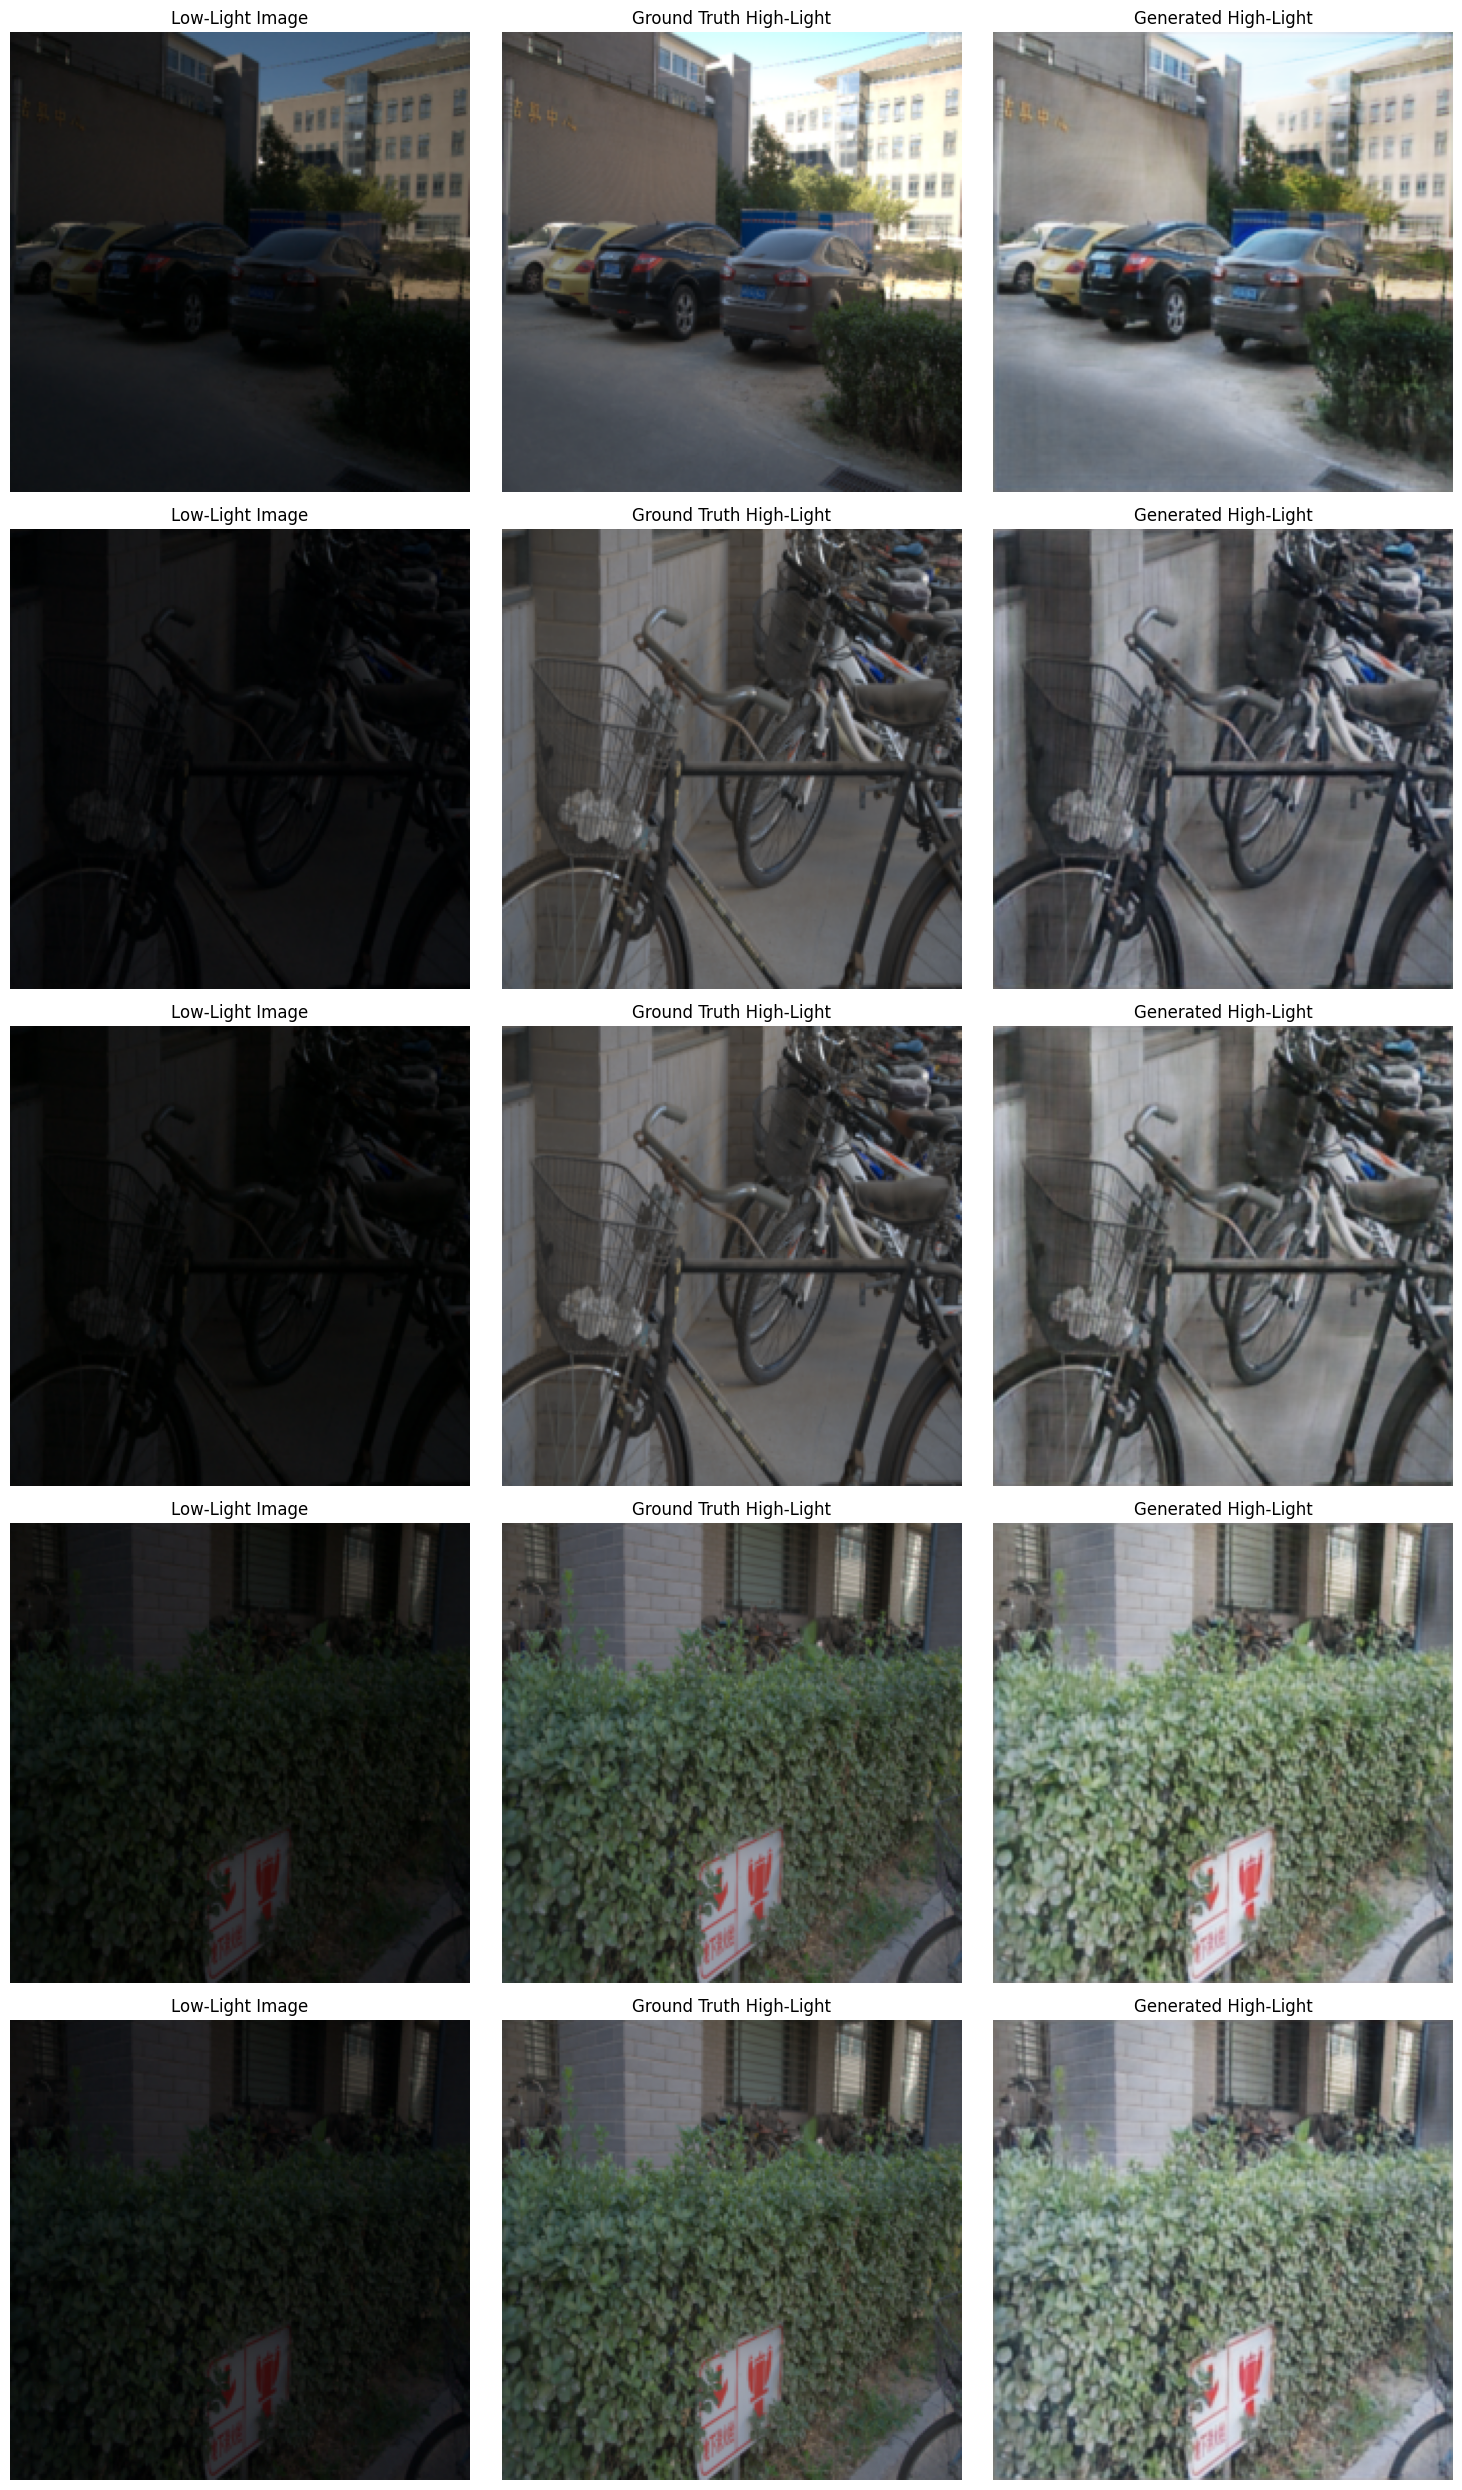

In [19]:
import matplotlib.pyplot as plt
import torch

def visualize_results(generator, test_loader, num_images=5):
    
    """
    Visualize low-light images, ground truth high-light images, and generated high-light images side by side.

    Args:
        generator:  Our Trained model (generator).
        test_loader: DataLoader for the test dataset.
        num_images: Number of images to visualize.
        
    """
    # Setting the model to evaluation mode
    generator.eval()

    # Get a batch of data from the test loader
    low_light_batch, high_light_batch = next(iter(test_loader))

    # Move data to the correct device (e.g., GPU)
    device = next(generator.parameters()).device
    low_light_batch = low_light_batch.to(device)
    high_light_batch = high_light_batch.to(device)

    # Generate enhanced images using the model
    with torch.no_grad():
        enhanced_batch = generator(low_light_batch)

    # Move tensors back to CPU for visualization
    low_light_batch = low_light_batch.cpu()
    high_light_batch = high_light_batch.cpu()
    enhanced_batch = enhanced_batch.cpu()

    # Clip pixel values to the valid range [0, 1]
    enhanced_batch = torch.clamp(enhanced_batch, 0, 1)

    # Plot the images
    plt.figure(figsize=(15, 5 * num_images))
    for i in range(num_images):
        
        # Low-light image
        plt.subplot(num_images, 3, 3 * i + 1)
        plt.imshow(low_light_batch[i].permute(1, 2, 0))  # Converting from (C, H, W) to (H, W, C)
        plt.title("Low-Light Image")
        plt.axis("off")

        # Ground truth high-light image
        plt.subplot(num_images, 3, 3 * i + 2)
        plt.imshow(high_light_batch[i].permute(1, 2, 0))  
        plt.title("Ground Truth High-Light")
        plt.axis("off")

        # Generated high-light image
        plt.subplot(num_images, 3, 3 * i + 3)
        plt.imshow(enhanced_batch[i].permute(1, 2, 0)) 
        plt.title("Generated High-Light")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_results(generator, test_loader, num_images=5)

In [15]:

transform = transforms.Compose([
    transforms.Resize((225,225)),
    transforms.ToTensor()
])

# creating a simple file upload widget
upload_widget = widgets.FileUpload(accept='image/*', multiple=False)

def on_upload_change(change):
    clear_output(wait=True)
    display(upload_widget)
    
    # Iterate over the file dictionaries directly
    for file_info in upload_widget.value:
        filename = file_info['name']  # Extract filename from the dictionary
        image_bytes = file_info['content']
        pil_image = Image.open(io.BytesIO(image_bytes)).convert('RGB')
        
        # Transform image and add a batch dimension
        input_tensor = transform(pil_image).unsqueeze(0).to(device)
        
        # Generate enhanced image
        generator.eval()
        with torch.no_grad():
            enhanced_tensor = generator(input_tensor)
        enhanced_tensor = torch.clamp(enhanced_tensor, 0, 1).cpu().squeeze(0)
        
        # Convert tensor to image for display
        enhanced_image = transforms.ToPILImage()(enhanced_tensor)
        
        # Plot the original and enhanced images side by side
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.imshow(pil_image)
        plt.title("Original Low-Light")
        plt.axis("off")
        
        plt.subplot(1,2,2)
        plt.imshow(enhanced_image)
        plt.title("Enhanced High-Light")
        plt.axis("off")
        
        plt.show()



In [16]:
# Attach the handler to the widget
upload_widget.observe(on_upload_change, names='value')

# Display the widget
display(upload_widget)

FileUpload(value=(), accept='image/*', description='Upload')